# set up

In [393]:
from pypdf import PdfReader
import pandas as pd
import os, re, math
import numpy as np
from scipy.sparse import dok_matrix
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, TruncatedSVD
from mpl_toolkits.mplot3d import Axes3D

In [394]:
meta_data = pd.read_csv("article-metadata.csv")
meta_data

,title,year,journal,topic,short_name,main_pages
0,Neural networks and physical systems with emer...,1982,PNAS,model,neural-nets,5
1,Learning representations by back-propagating e...,1986,Nature,model,backprop,4
2,ImageNet Classification with Deep Convolutiona...,2012,NeurIPS,model,cnn,8
3,Deep learning,2015,Nature,model,deep-learning,7
4,Deep Residual Learning for Image Recognition,2016,CVPR,vis,resnet,8
5,Attention Is All You Need,2017,NeurIPS,model,attention,9
6,CheXNet: Radiologist-Level Pneumonia Detection...,2017,arXiv,radiology,chexnet,5
7,Densely Connected Convolutional Networks,2017,CVPR,vis,densenet,8
8,Cardiologist-level arrhythmia detection and cl...,2019,Nature,cardiology,ecg,6
9,Language Models are Unsupervised Multitask Lea...,2019,OpenAI,LLM,gpt-2,10


In [395]:
article_to_main_pages = dict(zip(meta_data["short_name"], meta_data["main_pages"]))

## PDF text extraction

In [396]:
# reader = PdfReader("articles/attention.pdf")
# reader.pages[0].extract_text()

In [397]:
# write a helper function to extract all the text from the pdf
def extract_full_text_from_pdf(pdf_name):
    pdf_path = "articles/" + pdf_name + ".pdf"
    main_pages = article_to_main_pages[pdf_name]
    reader = PdfReader(pdf_path)
    text = ""   
    for page in reader.pages[0: main_pages]:
        raw_text = page.extract_text()
        text += raw_text
    return text

# extract all the text from the pdfs stored at `articles/` and organize them into a dict
docname_to_ls_of_strs = {}
for pdf_name in article_to_main_pages.keys():
    raw_text = extract_full_text_from_pdf(pdf_name)
    # remove all whitespace, numbers, and special characters, and convert to lowercase
    # TODO: clean this up later on
    cleaned_ls_of_strs = [re.sub(r'(^-+|-+$)', '', re.sub(r'[^\w\s-]|[\d]', '', term)).lower() \
            for term in raw_text.split()]
    cleaned_ls_of_strs = [term for term in cleaned_ls_of_strs if term != ""]
    docname_to_ls_of_strs[pdf_name] = cleaned_ls_of_strs

docname_to_ls_of_strs

{'neural-nets': ['proc',
  'natl',
  'acad',
  'sci',
  'usavol',
  'pp',
  'april',
  'biophysics',
  'neural',
  'networks',
  'and',
  'physical',
  'systems',
  'with',
  'emergent',
  'collective',
  'computational',
  'abilitiesassociative',
  'memoryparallel',
  'processingcategorizationcontent-addressable',
  'memoryfail-soft',
  'devices',
  'j',
  'j',
  'hopfield',
  'division',
  'of',
  'chemistry',
  'and',
  'biology',
  'california',
  'institute',
  'of',
  'technology',
  'pasadena',
  'california',
  'and',
  'bell',
  'laboratories',
  'murray',
  'hill',
  'new',
  'jersey',
  'contributed',
  'by',
  'john',
  'j',
  'hopfweld',
  'january',
  'abstract',
  'computational',
  'properties',
  'of',
  'use',
  'to',
  'biological',
  'or',
  'ganisms',
  'or',
  'to',
  'the',
  'construction',
  'of',
  'computers',
  'can',
  'emerge',
  'as',
  'col',
  'lective',
  'properties',
  'of',
  'systems',
  'having',
  'a',
  'large',
  'number',
  'of',
  'simple',
 

## compute TF-IDF

In [398]:
def compute_tf_for_a_doc(doc_ls_of_strs: list[str]) -> dict:
    '''compute the term frequency of each term in the document and return a dict of the counts'''
    total_terms = len(doc_ls_of_strs)
    term_to_tf = {}
    for term in doc_ls_of_strs:
        term_to_tf[term] = term_to_tf.get(term, 0) + 1
    
    for term in term_to_tf:
        term_to_tf[term] /= total_terms
    return term_to_tf

In [399]:
def compute_tf_idf_for_a_doc(current_doc_tf_dict: dict, other_docs_ls_of_dict: list[dict]) -> dict:
    '''
    compute the tf-idf of each term in the document and return a dict 
    idf = log(number of documents / number of documents that contain the word)
    '''
    n_total_docs = len(other_docs_ls_of_dict) + 1
    current_doc_tf_idf_dict = {}
    for term in current_doc_tf_dict:
        n_docs_with_term = 1 + sum(1 for other_doc in other_docs_ls_of_dict if term in other_doc)
        current_doc_tf_idf_dict[term] = current_doc_tf_dict[term] * math.log(n_total_docs / n_docs_with_term)
    return current_doc_tf_idf_dict

docname_to_dict_of_tf = {doc_name: compute_tf_for_a_doc(doc_ls_of_strs) for doc_name, doc_ls_of_strs in docname_to_ls_of_strs.items()}

docname_to_dict_of_tfidf = {}
for doc_name in docname_to_dict_of_tf:
    doc_tf_dict = docname_to_dict_of_tf[doc_name]
    other_docs_ls_of_strs = [docname_to_ls_of_strs[other_doc_name] for other_doc_name in docname_to_ls_of_strs if other_doc_name != doc_name]
    docname_to_dict_of_tfidf[doc_name] = compute_tf_idf_for_a_doc(doc_tf_dict, other_docs_ls_of_strs)

docname_to_dict_of_tfidf

{'neural-nets': {'proc': 0.0008494450742156192,
  'natl': 0.001229547390038742,
  'acad': 0.0010721222676661332,
  'sci': 0.0013100561934475256,
  'usavol': 0.0006118734218860276,
  'pp': 0.0008494450742156192,
  'april': 0.0003874836570436849,
  'biophysics': 0.0023514962142504557,
  'neural': 7.33360009625926e-05,
  'networks': 0.00010759856582702855,
  'and': 0.0,
  'physical': 0.006113890157051184,
  'systems': 0.001304751137610738,
  'with': 0.0,
  'emergent': 0.0028217954571005464,
  'collective': 0.006587222169742643,
  'computational': 0.0006463445255248343,
  'abilitiesassociative': 0.0006118734218860276,
  'memoryparallel': 0.0006118734218860276,
  'processingcategorizationcontent-addressable': 0.0006118734218860276,
  'memoryfail-soft': 0.0006118734218860276,
  'devices': 0.0015499346281747396,
  'j': 0.001384155215448512,
  'hopfield': 0.003059367109430138,
  'division': 0.0006574501276283089,
  'of': 0.0,
  'chemistry': 0.0009405984857001822,
  'biology': 0.000566296716143

In [400]:
# transform `docname_to_dict_of_tfidf` into a matrix
all_terms = {term for doc_dict in docname_to_dict_of_tfidf.values() for term in doc_dict.keys()}
all_terms

{'relaxation',
 'submitting',
 'contralateral',
 'blockade',
 'publishers',
 'discovers',
 'monomeric',
 'rouge',
 'parallelizable',
 'terminus',
 'retccl',
 'similarly-sized',
 'say',
 'dition',
 'ﬁlters',
 'unintelligible',
 'suis',
 'combined',
 'dont',
 'rocs',
 'analytics',
 'methodologies',
 'here',
 'lished',
 'image-omic',
 'encodes',
 'novel',
 'nerr',
 'won',
 'integrative',
 'efﬁcient',
 'ﬁ',
 'arated',
 'biennially',
 '_',
 'chris',
 'franken',
 'themselves',
 'gln',
 'classiﬁca',
 'turkers',
 'modern',
 'upjohn',
 'commu',
 'offset',
 'sharp',
 'competition',
 'exclusivity',
 'tokenizer',
 'orig',
 'nilsback',
 'rially',
 'charac',
 'schroeder',
 'tanhx',
 'decoders',
 'hospital',
 'communicate',
 'splits',
 'interresidue',
 'segmenting',
 'rie',
 'pre-trained',
 'library',
 'lgnvvvit',
 'shannonsm',
 'shaded',
 'model',
 'comparative',
 'mr',
 'national',
 'tiling',
 'pharmacovigilance',
 'short-term',
 'peters',
 'node',
 'drug-disease',
 'tohigher',
 'rectiﬁed',
 'needs

In [401]:
df_tfidf = pd.DataFrame(0.0, index=docname_to_dict_of_tfidf.keys(), columns=sorted(all_terms))

for doc, tfidf_dict in docname_to_dict_of_tfidf.items():
    for term, tfidf in tfidf_dict.items():
        df_tfidf.at[doc, term] = tfidf
df_tfidf

,_,__,________,_________,__________________,___ct_o_b_e_r___,__a,__e,_natu_r_e_v_o_l_,_s,...,ﬁxed-length,ﬁxing,ﬂexible,ﬂip,ﬂippingchexnet,ﬂoating,ﬂoating-point,ﬂops,ﬂow,ﬂuid
neural-nets,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000
backprop,0.006467,0.002156,0.000719,0.001437,0.000719,0.000719,0.000719,0.000719,0.000719,0.000719,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000
cnn,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000
deep-learning,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000
resnet,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000346,0.001093,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000
attention,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00078,0.00078,0.00000,0.000494,0.000000
chexnet,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.001154,0.00000,0.00000,0.00000,0.000731,0.001154
densenet,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.002769,0.000000
ecg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000
gpt-2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000423,0.00000,0.000536,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000


# dim reduction

In [402]:
# normalize such that each row is a unit vector
tfidf_normalized = normalize(df_tfidf, norm='l2', axis=1)
tfidf_normalized.shape


(20, 11441)

## PCA

In [403]:
pca = PCA(n_components=15) 
pca_results = pca.fit_transform(tfidf_normalized)
df = pd.DataFrame(pca_results)
df.index = df_tfidf.index
df = pd.merge(df, meta_data, left_index=True, right_on = "short_name")
df.set_index("short_name", inplace=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,title,year,journal,topic,main_pages
short_name,,,,,,,,,,,,,,,,,,,,
neural-nets,-0.006203,0.115720,0.002760,-0.227553,-0.383744,-0.121807,-0.366891,0.380506,0.335727,0.188993,0.342523,-0.383030,0.101502,0.028879,0.016957,Neural networks and physical systems with emer...,1982,PNAS,model,5
backprop,0.016567,0.122099,-0.028130,-0.251733,-0.371788,-0.116622,-0.105581,0.106187,-0.702746,-0.208944,0.144600,0.130561,-0.311497,-0.055704,-0.023000,Learning representations by back-propagating e...,1986,Nature,model,4
cnn,-0.120203,0.225933,-0.062497,-0.122057,-0.309979,-0.168481,-0.027036,0.068785,0.437675,0.038684,-0.408078,0.517536,-0.194837,-0.117691,-0.087556,ImageNet Classification with Deep Convolutiona...,2012,NeurIPS,model,8
deep-learning,-0.046762,0.119140,-0.180718,-0.376582,-0.183140,-0.088554,0.155828,-0.186362,-0.196816,-0.018241,-0.326175,-0.084982,0.641857,0.106975,0.035637,Deep learning,2015,Nature,model,7
resnet,-0.146748,0.551910,-0.081730,0.451349,0.107582,0.002484,-0.136233,-0.092433,-0.060713,-0.060094,0.004206,-0.083095,0.046514,0.010271,-0.037165,Deep Residual Learning for Image Recognition,2016,CVPR,vis,8


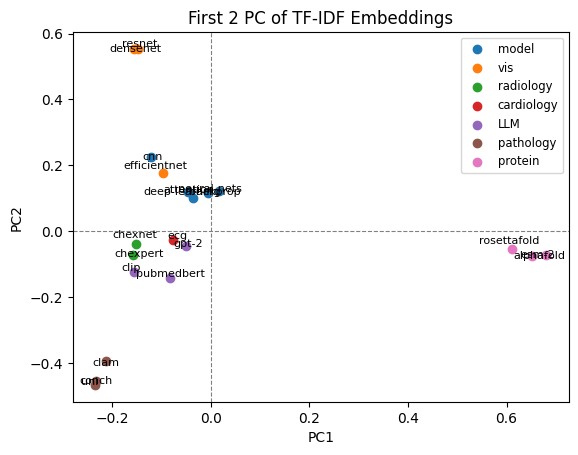

In [404]:
# Scatter plot with unique colors for each topic
unique_topics = df["topic"].unique()
colors = plt.get_cmap("tab10")

for i, topic in enumerate(unique_topics):
    subset = df[df["topic"] == topic]
    plt.scatter(subset[0], subset[1], color=colors(i), alpha=1, label=topic)

# Annotate points with decluttered annotations
for i, row in df.iterrows():
    plt.annotate(row.name, 
                 (row[0], row[1]), 
                 textcoords="offset points", 
                 xytext=(np.random.randint(-5, 5), np.random.randint(-5, 5)), 
                 ha="center", 
                 fontsize=8, 
                 alpha=1)

# Add lines to delineate x and y axis
plt.axhline(0, color='grey', linewidth=0.8, linestyle='--')
plt.axvline(0, color='grey', linewidth=0.8, linestyle='--')

# Labels and title
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("First 2 PC of TF-IDF Embeddings")
plt.legend(loc='best', fontsize='small')
plt.show()

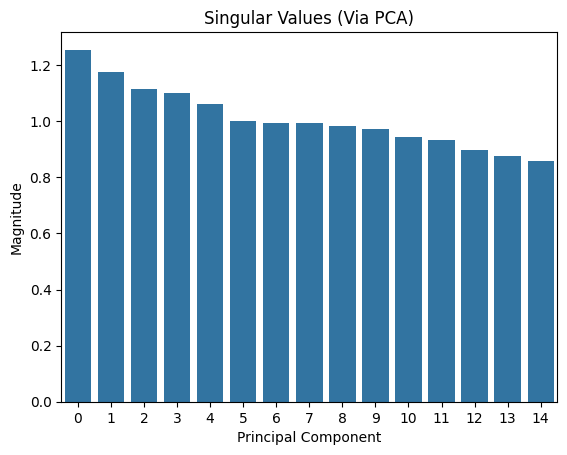

In [405]:
S = pca.singular_values_
sns.barplot(x=list(range(len(S))), y = S)
plt.title("Singular Values (Via PCA)")
plt.xlabel("Principal Component")
plt.ylabel("Magnitude")
plt.show()

## Truncated SVD
The following is just a sanity check (also out of curiousity) that truncated SVD and PCA are essentially the same (differing only by centering).

In [406]:
# center the data
tfidf_normalized_centered = tfidf_normalized - tfidf_normalized.mean(axis=0)
tsvd = TruncatedSVD(n_components=20, n_iter=100, random_state=42)
tsvd_results = tsvd.fit_transform(tfidf_normalized_centered)
df2 = pd.DataFrame(tsvd_results)
df2.index = df_tfidf.index
df2 = pd.merge(df2, meta_data, left_index=True, right_on = "short_name")
df2.set_index("short_name", inplace=True)
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,title,year,journal,topic,main_pages
short_name,,,,,,,,,,,,,,,,,,,,,
neural-nets,-0.006203,0.115720,0.002760,-0.227553,-0.383744,-0.121807,-0.366891,0.380506,0.335727,0.188993,...,-0.022011,-0.005835,0.001713,0.009131,5.555076e-17,Neural networks and physical systems with emer...,1982,PNAS,model,5
backprop,0.016567,0.122099,-0.028130,-0.251733,-0.371788,-0.116622,-0.105581,0.106187,-0.702746,-0.208944,...,-0.034897,-0.013387,0.000106,0.007743,-5.865908e-18,Learning representations by back-propagating e...,1986,Nature,model,4
cnn,-0.120203,0.225933,-0.062497,-0.122057,-0.309979,-0.168481,-0.027036,0.068785,0.437675,0.038684,...,-0.011252,-0.005854,0.015384,0.002105,6.397196e-17,ImageNet Classification with Deep Convolutiona...,2012,NeurIPS,model,8
deep-learning,-0.046762,0.119140,-0.180718,-0.376582,-0.183140,-0.088554,0.155828,-0.186362,-0.196816,-0.018241,...,0.011846,-0.007492,-0.010454,0.016187,1.583508e-17,Deep learning,2015,Nature,model,7
resnet,-0.146748,0.551910,-0.081730,0.451349,0.107582,0.002484,-0.136233,-0.092433,-0.060713,-0.060094,...,0.046075,-0.028044,0.562440,-0.026439,5.088869e-17,Deep Residual Learning for Image Recognition,2016,CVPR,vis,8


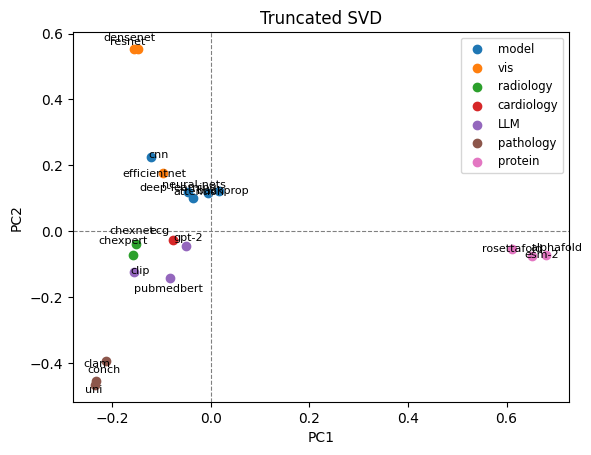

In [407]:
# Scatter plot with unique colors for each topic
unique_topics = df2["topic"].unique()
colors = plt.get_cmap("tab10")

for i, topic in enumerate(unique_topics):
    subset = df2[df2["topic"] == topic]
    plt.scatter(subset[0], subset[1], color=colors(i), alpha=1, label=topic)

# Annotate points with decluttered annotations
for i, row in df2.iterrows():
    plt.annotate(row.name, 
                 (row[0], row[1]), 
                 textcoords="offset points", 
                 xytext=(np.random.randint(-10, 10), np.random.randint(-10, 10)), 
                 ha="center", 
                 fontsize=8, 
                 alpha=1)

# Add lines to delineate x and y axis
plt.axhline(0, color='grey', linewidth=0.8, linestyle='--')
plt.axvline(0, color='grey', linewidth=0.8, linestyle='--')

# Labels and title
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Truncated SVD")
plt.legend(loc='best', fontsize='small')
plt.show()

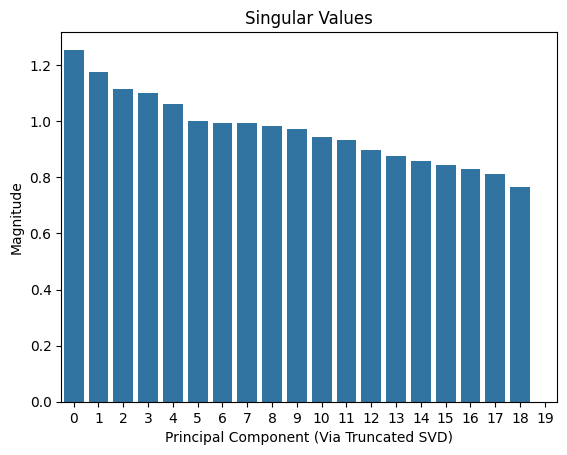

In [408]:
S2 = tsvd.singular_values_
sns.barplot(x=list(range(len(S2))), y = S2)
plt.title("Singular Values")
plt.xlabel("Principal Component (Via Truncated SVD)")
plt.ylabel("Magnitude")
plt.show()

In [409]:
pca.explained_variance_ratio_

array([0.08675277, 0.07626084, 0.06868494, 0.06671344, 0.06206161,
       0.05526957, 0.05443329, 0.05423469, 0.05325106, 0.05214628,
       0.04923219, 0.04798175, 0.04425621, 0.04224293, 0.0407401 ])

# interpretation
helpful ref: https://towardsdatascience.com/latent-semantic-analysis-intuition-math-implementation-a194aff870f8

In [410]:
# find the most important terms in the attention article
df_tfidf.T["conch"].sort_values(ascending=False).head(10)

conch              0.026060
zero-shot          0.014319
plip               0.014180
biomedclip         0.014180
visual-language    0.011880
openaiclip         0.008048
tcga               0.006553
sicap              0.006515
tiles              0.006132
retrieval          0.005498
Name: conch, dtype: float64

In [411]:
loadings = pd.DataFrame(pca.components_.T)
loadings.index = df_tfidf.columns

Find the top terms in each principal component direction:

In [412]:
loadings[0].sort_values(ascending=False).head(20)

protein        0.312296
alphafold      0.263188
proteins       0.230614
structure      0.211929
structures     0.200882
rosettafold    0.187564
casp           0.170615
esm            0.165423
pdb            0.140194
esmfold        0.139973
msa            0.136478
å              0.118676
chains         0.113261
tm-score       0.105351
residues       0.095429
metagenomic    0.085235
structural     0.081822
rmsd           0.077369
residue        0.077149
cameo          0.076988
Name: 0, dtype: float64

PC1 seems to be centered around protein structure.

In [413]:
loadings[1].sort_values(ascending=False).head(20)

conv             0.405970
plain            0.173426
feature-maps     0.150125
densenet         0.139718
densenets        0.126223
resnets          0.106664
densenet-bc      0.106540
resnet           0.100433
layers           0.095994
dense            0.094476
shortcuts        0.090483
efﬁcientnet-b    0.074101
residual         0.072542
ilsvrc           0.071710
layer            0.067236
neurons          0.064697
kernels          0.061172
svhn             0.058113
flops            0.056518
identity         0.055230
Name: 1, dtype: float64

PC2 is about different kinds of neural networks.

In [414]:
loadings[2].sort_values(ascending=False).head(20)

chexnet          0.315257
chest            0.305932
radiologists     0.253619
pneumonia        0.240779
rad              0.179098
uncertainty      0.166852
radiologist      0.156027
labeler          0.131339
pleural          0.118696
chestx-ray       0.113843
x-rays           0.113843
edema            0.105234
cardiomegaly     0.102788
na               0.096060
effusion         0.095519
consolidation    0.093611
mention          0.092436
uncertain        0.091865
auc              0.085667
atelectasis      0.084738
Name: 2, dtype: float64

PC3 is very medical and clinical.